In [296]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications import EfficientNetB0, MobileNetV2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

## **Импорт обучающего набора**

In [266]:
DATASET_DIR = 'Dataset'
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 2

train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '01_Train'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '02_Val'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '03_Test'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
print('Классы:', class_names)

Found 282 files belonging to 2 classes.
Found 60 files belonging to 2 classes.
Found 60 files belonging to 2 classes.
Классы: ['ImpactStructures', 'VolcanoStructures']


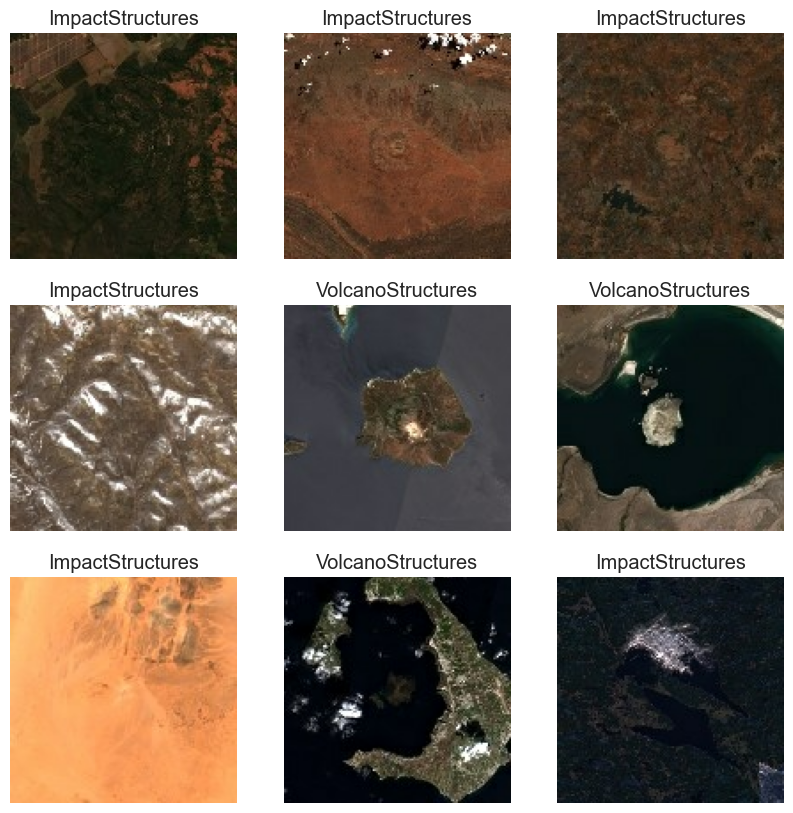

In [267]:
# Просмотр данных
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        class_idx = np.argmax(labels[i])
        plt.title(class_names[class_idx])
        plt.axis("off")

# **Модель на основе EfficientNetB0 (базовая)**

## **Разработка архитектуры**

In [268]:
# Загрузка базовой модели
EfficientNetB0_backbone = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Разрешаем обучение
EfficientNetB0_backbone.trainable = True

# Замораживаем все, кроме BatchNormalization
for layer in EfficientNetB0_backbone.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Входной слой
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# Аугментация
x = layers.RandomFlip('horizontal', name='augmentation_flip')(inputs)
x = layers.RandomRotation(0.15, fill_mode='reflect', name='augmentation_rotation')(x)
x = layers.RandomZoom(0.15, fill_mode='reflect', name='augmentation_zoom')(x)
x = layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', name='augmentation_translation')(x)
x = layers.RandomContrast(0.15, name='augmentation_contrast')(x)

# Бэкбон
x = EfficientNetB0_backbone(x, training=False)

# Новый классификатор
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Выходной слой
outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-4))(x)

# Сборка модели
base_model = keras.Model(inputs, outputs, name='EfficientNetB0_base_model')

# Компиляция модели
base_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

base_model.summary()

Model: "EfficientNetB0_base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_flip (RandomFlip)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_rotation                │ (None, 128, 128, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_zoom (RandomZoom)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_translation             │ (None, 128, 128, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_contrast                │ (None, 128, 128, 3)         │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_24          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,309 (16.08 MB)

 Trainable params: 206,498 (806.63 KB)

 Non-trainable params: 4,007,811 (15.29 MB)

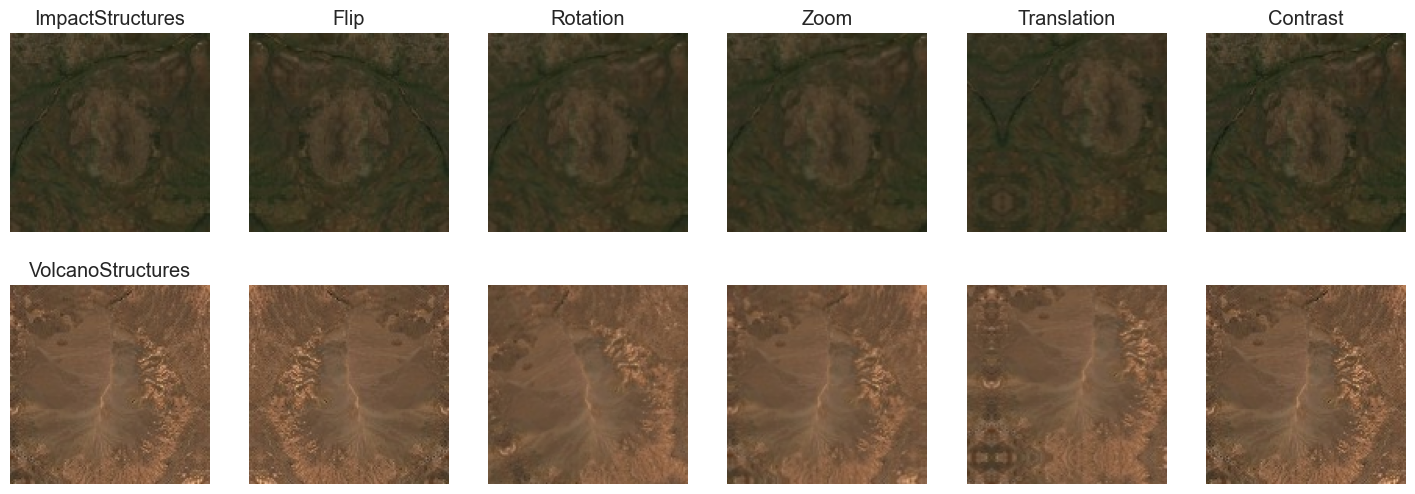

In [271]:
def visualize_6x6_fixed(model, dataset, class_names):
    layers_to_show = [
        ('augmentation_flip', 'Flip'),
        ('augmentation_rotation', 'Rotation'),
        ('augmentation_zoom', 'Zoom'),
        ('augmentation_translation', 'Translation'),
        ('augmentation_contrast', 'Contrast')
    ]
    
    num_cols = len(layers_to_show) + 1 

    indices_data = []
    found_classes = set()
    
    for images, labels in dataset:
        for i in range(len(images)):
            class_idx = np.argmax(labels[i])
            if class_idx not in found_classes:
                indices_data.append((images[i], class_names[class_idx]))
                found_classes.add(class_idx)
            if len(indices_data) == 6: break
        if len(indices_data) == 6: break

    num_rows = len(indices_data)

    plt.figure(figsize=(18, 3 * num_rows)) 
    
    for row_idx in range(num_rows):
        image, class_name = indices_data[row_idx]
        
        plt.subplot(num_rows, num_cols, row_idx * num_cols + 1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(class_name, fontweight='normal')
        plt.axis('off')

        for i, (layer_name, display_name) in enumerate(layers_to_show):
            layer = model.get_layer(layer_name)
            aug_img = layer(tf.expand_dims(image, 0), training=True)
            
            plt.subplot(num_rows, num_cols, row_idx * num_cols + i + 2)
            plt.imshow(tf.cast(aug_img[0], tf.uint8))
            
            if row_idx == 0:
                plt.title(display_name)
            plt.axis('off')
            
    plt.show()


visualize_6x6_fixed(base_model, train_ds, class_names)

## **Трансферное обучение**

In [272]:
# Колбеки
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

### **Обучение классификатора**

In [273]:
# Обучение классификатора
base_history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.5071 - loss: 1.1706 - val_accuracy: 0.4833 - val_loss: 0.7919 - learning_rate: 1.0000e-04
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.5922 - loss: 0.9543 - val_accuracy: 0.5333 - val_loss: 0.7521 - learning_rate: 1.0000e-04
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5603 - loss: 0.9834 - val_accuracy: 0.5667 - val_loss: 0.7266 - learning_rate: 1.0000e-04
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6809 - loss: 0.8441 - val_accuracy: 0.6167 - val_loss: 0.7074 - learning_rate: 1.0000e-04
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6809 - loss: 0.8351 - val_accuracy: 0.5833 - val_loss: 0.6882 - learning_rate: 1.0000e-04
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6418 - loss: 0.7971 - val_accuracy: 0.6333 - val_loss: 0.6712 - learning_rate: 1.0000e-04
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy:

#### **Оценка качества**

In [274]:
# Метрики на тесте
metrics = base_model.evaluate(test_ds)
metrics

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7333 - loss: 0.6005


[0.60047847032547, 0.7333333492279053]

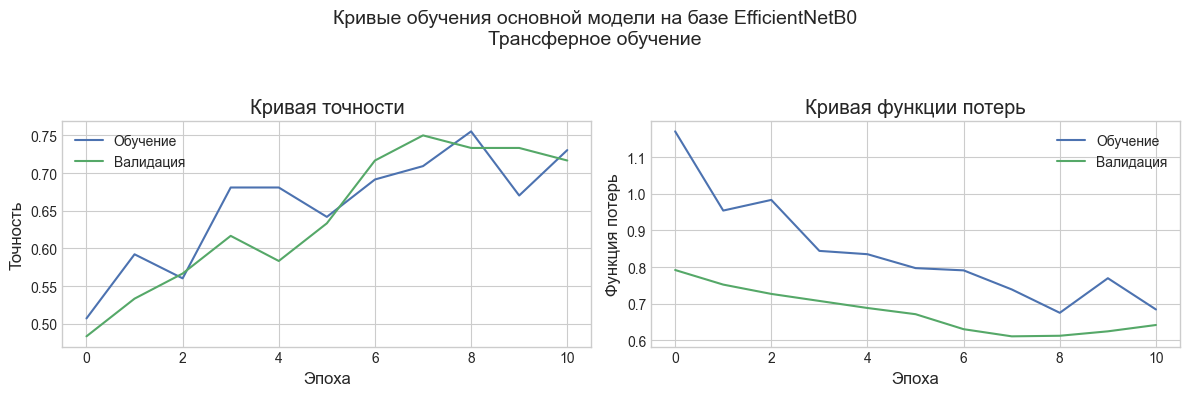

In [276]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения основной модели на базе EfficientNetB0\nТрансферное обучение',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig('Plots/lc_EfficientNetB0_model.png')
    plt.show()


# Визуализация кривых обучения, этап предобучения
plot_training_curves(base_history)

In [282]:
# Эпоха с которой забрали лучшие веса
val_metric_values = base_history.history['val_loss']
best_value = min(val_metric_values)
best_epoch_index = val_metric_values.index(best_value)
best_epoch_number = best_epoch_index + 1

print(f'Лучшие веса были достигнуты и восстановлены из эпохи номер: {best_epoch_number}')
print(f'Оптимальное значение val_loss: {best_value:.4f}')

Лучшие веса были достигнуты и восстановлены из эпохи номер: 8
Оптимальное значение val_loss: 0.6108


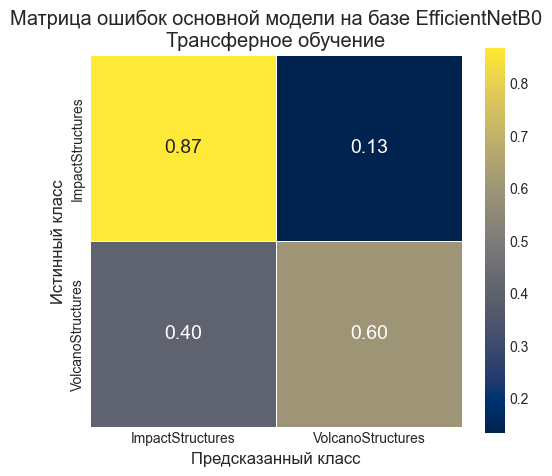

In [283]:
# Оценка качества модели
y_true_list = []
y_pred_list = []

for images, labels in test_ds:
    preds = base_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 14},
    fmt='.2f',
    cmap='cividis',
    square=True,
    linewidths=0.5,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок основной модели на базе EfficientNetB0\nТрансферное обучение')
plt.savefig('Plots/cm_EfficientNetB0_model.png')
plt.show()

#### **Интерпретация работы**

In [389]:
def get_gradcam_plus_plus_heatmap(img_tensor, model, last_conv_layer_name='out_relu', pred_index=None):
    # 1. Выделяем backbone и голову
    backbone = model.get_layer('efficientnetb0')
    
    # Создаем модель, которая выводит и карту активаций, и предсказание
    grad_model = tf.keras.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Записываем градиенты (нужен watch для активаций слоя)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor, training=False)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # 3. Вычисляем градиенты 1-го, 2-го и 3-го порядков
    # Примечание: Для 2-го и 3-го порядков нужны вложенные ленты
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape1:
            conv_outputs, predictions = grad_model(img_tensor, training=False)
            class_channel = predictions[:, pred_index]
        grads_1 = tape1.gradient(class_channel, conv_outputs) # первая производная
    grads_2 = tape2.gradient(grads_1, conv_outputs) # вторая производная
    
    # Для экономии ресурсов 3-ю производную часто аппроксимируют или 
    # используют еще один вложенный tape. Ограничимся честным расчетом:
    with tf.GradientTape() as tape3:
        with tf.GradientTape() as tape2_2:
            with tf.GradientTape() as tape1_2:
                conv_outputs, predictions = grad_model(img_tensor, training=False)
                class_channel = predictions[:, pred_index]
            grads_1_2 = tape1_2.gradient(class_channel, conv_outputs)
        grads_2_2 = tape2_2.gradient(grads_1_2, conv_outputs)
    grads_3 = tape3.gradient(grads_2_2, conv_outputs) # третья производная

    # 4. Расчет коэффициентов alpha (математика из статьи)
    # Используем только положительные элементы (ReLU на градиенты)
    inds_plus = tf.cast(grads_1 > 0, tf.float32)
    
    # Знаменатель: 2*f'' + conv_sum*f'''
    conv_sum = tf.reduce_sum(conv_outputs, axis=(1, 2), keepdims=True)
    denominator = 2 * grads_2 + conv_sum * grads_3
    denominator = tf.where(denominator != 0, denominator, 1e-10) # защита от нуля
    
    alphas = grads_2 / denominator
    alphas *= inds_plus # веса учитываются только для положительного влияния

    # 5. Итоговые веса каналов
    weights = tf.reduce_sum(alphas * tf.maximum(grads_1, 0), axis=(1, 2))

    # 6. Линейная комбинация и Heatmap
    # conv_outputs shape: (1, h, w, channels) * weights shape: (1, channels)
    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis, :] * conv_outputs, axis=-1)

    # Применяем ReLU (убираем отрицательные значения) и нормализуем
    heatmap = tf.maximum(cam, 0)
    max_val = tf.math.reduce_max(heatmap)
    if max_val != 0:
        heatmap /= max_val
    
    return heatmap[0].numpy()

In [390]:
# Визуализация
def plot_gradcam_comparison(img_path, heatmap, alpha=0.6):
    # Загрузка исходного снимка
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img) / 255.0

    # Подготовка Heatmap
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (128, 128))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()

    # Создание наложенного изображения (Superimposed)
    jet = cmap.get_cmap('jet')

    jet_colors = jet(heatmap_resized)

    jet_colors = jet_colors[:, :, :3]

    superimposed_img = jet_colors * alpha + img_array
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Макет для графика
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Исходный снимок (левый)
    axes[0].imshow(img_array)
    axes[0].set_title('Исходный снимок')
    axes[0].axis('off')

    # Чистый Grad-CAM (средний)
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    # Наложение (правый)
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Наложение')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [391]:
train_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))
val_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))
test_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))

# Вывод класс ImpactStructures
img_path = f'Dataset/03_Test/ImpactStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/ImpactStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/ImpactStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

ValueError: No such layer: top_conv. Existing layers are: ['input_layer', 'augmentation_flip', 'augmentation_rotation', 'augmentation_zoom', 'augmentation_translation', 'augmentation_contrast', 'efficientnetb0', 'global_average_pooling2d_24', 'dropout_48', 'dense_48', 'batch_normalization_24', 'dropout_49', 'dense_49'].

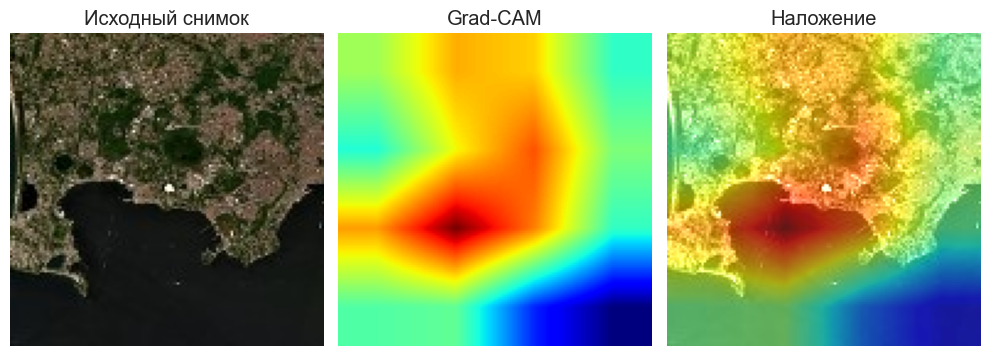

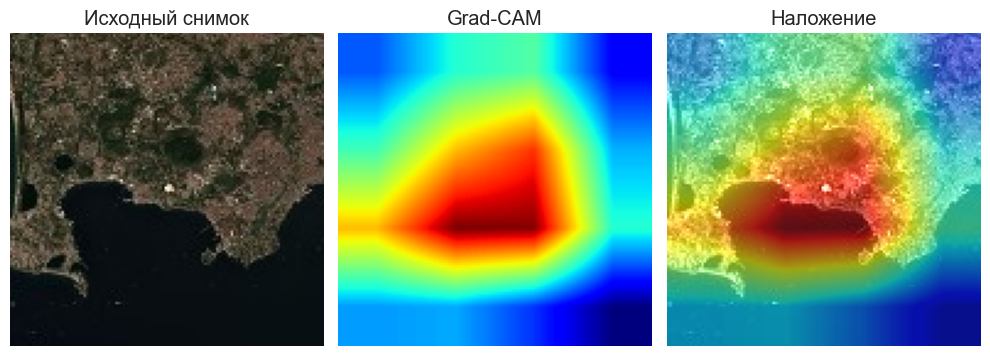

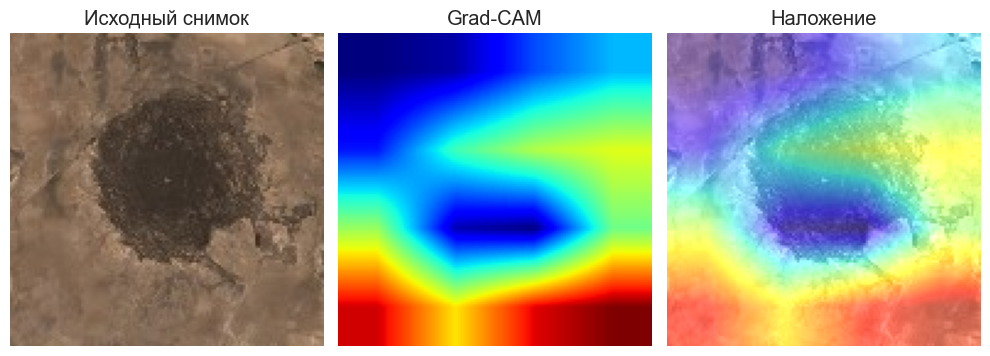

In [355]:
train_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))
val_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))
test_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))

# Вывод класс ImpactStructures
img_path = f'Dataset/03_Test/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

### **Сохранение модели**

In [352]:
# Сохранение схемы архитектуры модели
plot_model(base_model, to_file='Models/EfficientNetB0_base_model.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [353]:
# Сохранение модели
base_model.save('Models/EfficientNetB0_base_model.keras')

# **Модель на основе MobileNetV2 (альтернативная)**

## **Разработка архитектуры**

In [370]:
# Альтернативная модель
MobileNetV2_backbone = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Разрешаем обучение
MobileNetV2_backbone.trainable = False

# Замораживаем все, кроме BatchNormalization
for layer in MobileNetV2_backbone.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

# Вход
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# Аугментация
x = layers.RandomFlip('horizontal', name='augmentation_flip')(inputs)
x = layers.RandomRotation(0.15, name='augmentation_rotation')(x)
x = layers.RandomZoom(0.15, name='augmentation_zoom')(x)
x = layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', name='augmentation_translation')(x)
x = layers.RandomContrast(0.15, name='augmentation_contrast')(x)

# Предобработка и базовая модель
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = MobileNetV2_backbone(x, training=False)

# Новая голова
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Выход
outputs = layers.Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=keras.regularizers.l2(1e-4))(x)

# Сборка модели
alt_model = keras.Model(inputs, outputs, name='MobileNetV2_alt_model')

alt_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

alt_model.summary()

Model: "MobileNetV2_alt_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_flip (RandomFlip)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_rotation                │ (None, 128, 128, 3)         │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_zoom (RandomZoom)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_translation             │ (None, 128, 128, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_contrast                │ (None, 128, 128, 3)         │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_5 (TrueDivide)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_5 (Subtract)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_27          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,722 (9.24 MB)

 Trainable params: 198,594 (775.76 KB)

 Non-trainable params: 2,224,128 (8.48 MB)

## **Трансферное обучение**

### **Обучение классификатора**

In [371]:
# Обучение классификатора
alt_history = alt_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.5461 - loss: 1.1615 - val_accuracy: 0.5500 - val_loss: 0.8103 - learning_rate: 1.0000e-04
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.5745 - loss: 1.0900 - val_accuracy: 0.5333 - val_loss: 0.7793 - learning_rate: 1.0000e-04
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6397 - loss: 0.9386
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.6135 - loss: 1.0002 - val_accuracy: 0.5500 - val_loss: 0.7657 - learning_rate: 1.0000e-04


#### **Оценка качества**

In [372]:
# Метрики на тесте
metrics = alt_model.evaluate(test_ds)
metrics

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6500 - loss: 0.7029


[0.7029390335083008, 0.6499999761581421]

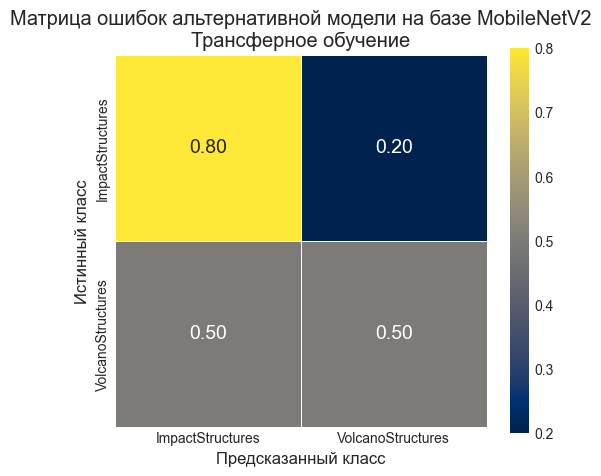

In [373]:
# Оценка качества модели
y_true_list = []
y_pred_list = []

for images, labels in test_ds:
    preds = alt_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 14},
    fmt='.2f',
    cmap='cividis',
    square=True,
    linewidths=0.5,
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок альтернативной модели на базе MobileNetV2\nТрансферное обучение')
plt.savefig('Plots/cm_MobileNetV2_model.png')
plt.show()

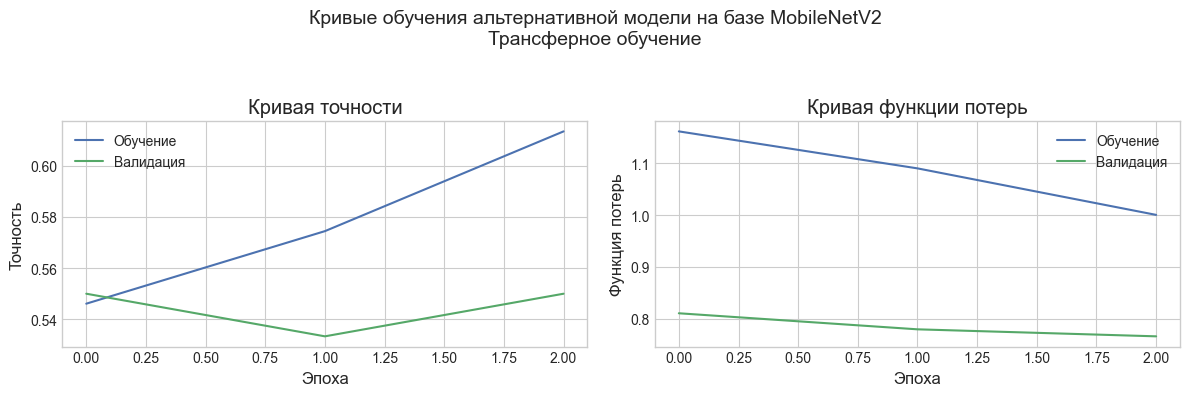

In [374]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения альтернативной модели на базе MobileNetV2\nТрансферное обучение',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig('Plots/lc_MobileNetV2_model.png')
    plt.show()


# Визуализация кривых обучения
plot_training_curves(alt_history)

#### **Интерпретация работы**

In [376]:
# Grad-CAM++
def get_gradcam_plus_plus_heatmap(img_tensor, model, last_conv_layer_name='out_relu', pred_index=None):
    backbone = model.get_layer('mobilenetv2_1.00_128') 

    found = False
    head_layers = []
    for layer in model.layers:
        if found:
            head_layers.append(layer)
        if layer == backbone:
            found = True

    with tf.GradientTape(persistent=True) as tape: 

        inner_model = tf.keras.Model(
            inputs=backbone.inputs,
            outputs=[backbone.get_layer(last_conv_layer_name).output, backbone.output]
        )

        conv_outputs, backbone_features = inner_model(img_tensor, training=False)
        
        conv_outputs = tf.cast(conv_outputs, dtype=tf.float32)
        tape.watch(conv_outputs)

        y = backbone_features
        for layer in head_layers:
            y = layer(y, training=False)

        predictions = y

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    grads2 = tape.gradient(grads, conv_outputs)
    grads3 = tape.gradient(grads2, conv_outputs)

    global_sum = tf.reduce_sum(conv_outputs, axis=(0, 1))

    alpha_num = grads
    alpha_den = grads2 * 2.0 + grads3 * global_sum[:, tf.newaxis, tf.newaxis, tf.newaxis]
    alpha_den = tf.where(tf.equal(alpha_den, 0.0), tf.ones_like(alpha_den), alpha_den)
    alpha = alpha_num / alpha_den + tf.cast(grads3 * global_sum[:, tf.newaxis, tf.newaxis, tf.newaxis], dtype=tf.float32)

    weights = tf.reduce_mean(alpha, axis=(1, 2))

    cam = tf.reduce_sum(weights[:, tf.newaxis, tf.newaxis, tf.newaxis] * conv_outputs, axis=-1)

    heatmap = tf.maximum(cam, 0)
    heatmap /= (tf.math.reduce_max(heatmap) + 1e-10)
    
    del tape 
    
    return heatmap.numpy().squeeze()

In [377]:
# Визуализация
def plot_gradcam_comparison(img_path, heatmap, alpha=0.6):
    # Загрузка исходного снимка
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img) / 255.0

    # Подготовка Heatmap
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (128, 128))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()

    # Создание наложенного изображения (Superimposed)
    jet = cmap.get_cmap('jet')

    jet_colors = jet(heatmap_resized)

    jet_colors = jet_colors[:, :, :3]

    superimposed_img = jet_colors * alpha + img_array
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Макет для графика
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Исходный снимок (левый)
    axes[0].imshow(img_array)
    axes[0].set_title('Исходный снимок')
    axes[0].axis('off')

    # Чистый Grad-CAM (средний)
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    # Наложение (правый)
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Наложение')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [380]:
train_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))
val_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))
test_structure = random.choice(os.listdir('Dataset/03_Test/ImpactStructures/'))

# Вывод класс ImpactStructures
img_path = f'Dataset/03_Test/ImpactStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/ImpactStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/ImpactStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_plus_plus_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

TypeError: Argument `target` should be a list or nested structure of Tensors, Variables or CompositeTensors to be differentiated, but received None.

In [379]:
train_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))
val_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))
test_structure = random.choice(os.listdir('Dataset/03_Test/VolcanoStructures/'))

# Вывод класс ImpactStructures
img_path = f'Dataset/03_Test/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'out_relu')
plot_gradcam_comparison(img_path, heatmap)

ValueError: No such layer: efficientnetb0. Existing layers are: ['input_layer', 'augmentation_flip', 'augmentation_rotation', 'augmentation_zoom', 'augmentation_translation', 'augmentation_contrast', 'mobilenetv2_1.00_128', 'global_average_pooling2d_27', 'dropout_54', 'dense_54', 'batch_normalization_27', 'dropout_55', 'dense_55'].

## **Сохранение модели**

In [25]:
# Сохранение схемы архитектуры модели
plot_model(alt_model, to_file='Models/MobileNetV2_alt_model.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [26]:
# Сохранение модели
alt_model.save('Models/MobileNetV2_alt_model.keras')